<a href="https://colab.research.google.com/github/kirbyju/TCIA_Notebooks/blob/main/TCIA_with_ITK_and_itkWidgets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Summary
Access to large, high quality data is essential for researchers to understand disease and precision medicine pathways, especially in cancer. However HIPAA constraints make sharing medical images outside an individual institution a complex process. [The Cancer Imaging Archive (TCIA)](https://www.cancerimagingarchive.net/) is a public service funded by the National Cancer Institute which addresses this challenge by providing hosting and de-identification services to take major burdens of data sharing off researchers. 

# 1 TCIA Basics

[Browsing Collections](https://www.cancerimagingarchive.net/collections) and [Analysis Results](https://www.cancerimagingarchive.net/tcia-analysis-results/) datasets on TCIA are the easiest ways to become familiar with what is available.  These pages will help you quickly identify datasets of interest, find valuable supporting data that are not available via our APIs (e.g. clinical spreadsheets, non-DICOM segmentation data), and answer most common questions you might have about the datasets.  

If you are new to accessing TCIA via notebooks you can find additional tutorials on querying and downloading data at https://github.com/kirbyju/TCIA_Notebooks.

# 2 Use cases
In this section we'll download a few datasets from TCIA to show off the functionality of ITK and itkWidgets by demonstrating the following use cases:

1. Loading DICOM Images and associated DICOM RTStruct objects from TCIA
2. Locaing DICOM Images and associated DICOM SEG objects from TCIA

## 2.1. Loading DICOM Images and associated DICOM RTStruct objects from TCIA

### 2.1.1 Install dependencies

In [1]:
import sys

# Upgrade pip, just in case...
!{sys.executable} -m pip install --upgrade -q pip

# Install itk for DICOM I/O and for reading DICOM into an itkImage that manages all DICOM field values, include acquistion details 
#   such as voxel image, image orientation, and image directions which are critical to image processing and display
!{sys.executable} -m pip install --upgrade --pre -q itk

# Install rt-utils for reading DICOM RT-Struct objects
!{sys.executable} -m pip install --upgrade -q rt-utils

# Install pydicom-seg for reading DICOM SEG objects
!{sys.executable} -m pip install --upgrade -q pydicom-seg

# Install pandas for managing the TCIA manifest data and downloaded meta-data
!{sys.executable} -m pip install --upgrade -q pandas

# Install itkWidgets for 2D and 3D visualization within the notebook
!{sys.executable} -m pip install --upgrade -q itkwidgets

### 2.1.2. Import dependencies

In [2]:
# TCIA data import utils
import requests
import json
import requests, zipfile
import pandas as pd
from io import BytesIO

# Include ITK for DICOM reading
import itk

# Include numpy which is used by pydicom-seg and rt_utils
import numpy as np

# Pydicom-Seg is a layer on top of pydicom that handles DICOM SEG objects.
import pydicom
import pydicom_seg

# RT-Utils is a layer on top of pydicom that provides a convenient way to read RT-STRUCT DICOM contours and
#   generate labelmaps from them.  Labelmaps are needed for most deep learning segmentation tasks
from rt_utils import RTStructBuilder

# To visualize the data, we use the view() function from itkWidgets
from itkwidgets import view

### 2.1.3. Download data from TCIA

In [4]:
# Download a "Shared Cart" that has been previously created via the NBIA webset (https://nbia.cancerimagingarchive.net)
cartName = "nbia-49121659384603347"

cart_URL = "https://services.cancerimagingarchive.net/nbia-api/services/v1/getContentsByName?name=" + cartName
cart_data = requests.get( cart_URL ).json()

# Convert the metadata downloaded to a pandas dataframe for easy access and manipulation
df = pd.DataFrame( cart_data )

display(df)

# Here are the URLs that correspond to the series in that study
series_uids = [ seriesUID for seriesUID in df['SeriesInstanceUID'] ]
# Go through the Series in the cart, and download them
TCIA_base_url = "https://services.cancerimagingarchive.net/nbia-api/services/v1/getImage?SeriesInstanceUID="
dicom_data_dir = "dicomData/"
for series_uid in series_uids:
        print( "Downloading", series_uid )
        request = requests.get( TCIA_base_url + series_uid )
        file = zipfile.ZipFile( BytesIO(request.content) )
        file.extractall( path = dicom_data_dir + series_uid )
        print("   ...done.")

SeriesInstanceUID  \
0  1.2.276.0.7230010.3.1.3.1070885483.15960.15991...   
1  1.3.6.1.4.1.14519.5.2.1.1446730703023542404050...   
2  1.3.6.1.4.1.14519.5.2.1.6673411903393211051343...   
3  1.3.6.1.4.1.14519.5.2.1.7311.5101.206828891270...   

                                    StudyInstanceUID  Modality  \
0  1.3.6.1.4.1.14519.5.2.1.7311.5101.170561193612...       SEG   
1  1.3.6.1.4.1.14519.5.2.1.8859670961354389003042...  RTSTRUCT   
2  1.3.6.1.4.1.14519.5.2.1.8859670961354389003042...        CT   
3  1.3.6.1.4.1.14519.5.2.1.7311.5101.170561193612...        MR   

              SeriesDate SeriesDescription BodyPartExamined  SeriesNumber  \
0  2020-09-03 00:00:00.0      Segmentation         PROSTATE           300   
1                    NaN          RTSTRUCT              NaN             2   
2  2009-10-09 00:00:00.0                CT          ABDOMEN         30144   
3  2011-10-18 00:00:00.0        t2_tse_tra         PROSTATE             5   

         Collection                  PatientID            Manufacturer  \
0         PROSTATEx             ProstateX-0004                   QIICR   
1  Pediatric-CT-SEG  Pediatric-CT-SEG-00DCF4D6  Varian Medical Systems   
2  Pediatric-CT-SEG  Pediatric-CT-SEG-00DCF4D6      GE MEDICAL SYSTEMS   
3         PROSTATEx             ProstateX-0004                 SIEMENS   

                ManufacturerModelName SoftwareVersions  ImageCount  \
0  https://github.com/qiicr/dcmqi.git          1e82977           1   
1                            ARIA RTM          4.2.7.0           1   
2                       Revolution CT   revo_ct_21a.33         207   
3                               Skyra     syngo MR D11          19   

  ProtocolName  
0          NaN  
1          NaN  
2          NaN  
3   t2_tse_tra

   ...done.
   ...done.
   ...done.
   ...done.


### 2.1.4. Identify CT and RTSTRUCT data from the Pediatric-CT-SEG study

In [5]:
# The Pediatric-CT-SEG study provides DICOM images and DICOM RTSTRUCT data
ped_study_df = df.query( 'Collection=="Pediatric-CT-SEG"')
# The series_uid defines their directory where the CT data was stored on disk
ped_ct_series_uid = ped_study_df.SeriesInstanceUID[ped_study_df.Modality.eq('CT').idxmax()]
ped_ct_dir = dicom_data_dir + ped_ct_series_uid
# The series_uid defines where the RTSTRUCT was stored on disk.  It is stored in a single file.
ped_rtstruct_series_uid = ped_study_df.SeriesInstanceUID[ped_study_df.Modality.eq('RTSTRUCT').idxmax()]
ped_rtstruct_file = dicom_data_dir + ped_rtstruct_series_uid + "/00000001.dcm"

### 2.1.5. Read and visualize CT and RTSTRUCT data from the Pediatric-CT-SEG study

In [6]:
# Read the DICOM CT series' objects and reconstruct them into a 3D ITK image
#   The itk.F option is added to store the image in memory using floating-point precision pixels (useful if you will filter the image or use it with MONAI)
#   For more info on imread, see https://itkpythonpackage.readthedocs.io/en/master/Quick_start_guide.html 
ped_ct_image = itk.imread(ped_ct_dir, itk.F)

# We use RT-Utils to read in the list of contours (ROIs) available in the RT-STRUCT file.  This also requires passing-in the path to the original
#   DICOM series (image) so that labelmaps images can be generated from the RT-STRUCT contours.
ped_rtstruct = RTStructBuilder.create_from(dicom_series_path=ped_ct_dir, rt_struct_path=ped_rtstruct_file)
# Read in the bones contour as a numpy array.  We must also convert convert it to float (for possible future filtering, MONAI, etc.), and realign the axis to 
#   correspond with how images are stored by ITK.  This realignment typically isn't needed, but rt-utils requires it.
#   Note: The copy() call is required to force the transpose to actually reorder the data in memory versus maintain an abstraction.
ped_bones_array = ped_rtstruct.get_roi_mask_by_name("Bones").astype(np.float32).transpose(2,0,1).copy()
# As an np array, the rtstruct labelmap is missing critical information about pixel spacing, image origin, image orientation, etc.
#    Here we create an itk image from the numpy array, and we copy the critical information from itk image created from the 
#    original DICOM CT data.
ped_bones_labelmap = itk.GetImageFromArray(ped_bones_array)
ped_bones_labelmap.CopyInformation(ped_ct_image)

In [7]:
# RT-Utils has many useful functions, including the ability to list the names of the ROIs available in the RT-STRUCT file
print(ped_rtstruct.get_roi_names())

['Bones', 'Skin', 'Lung_R', 'UteroCervix', 'Thymus', 'Stomach', 'Spleen', 'Spinal Canal', 'Small Intestine', 'Rectum', 'Prostate', 'Pancreas', 'Liver', 'Large Intestine', 'Kidney Right', 'Kidney Left', 'Heart', 'Gonads', 'Gall Bladder', 'Femoral Head Rig', 'Femoral Head Lef', 'Esophagus', 'Duodenum', 'Breast Right', 'Breast Left', 'Bladder', 'Adrenal Right', 'Adrenal Left', 'Lung_L']



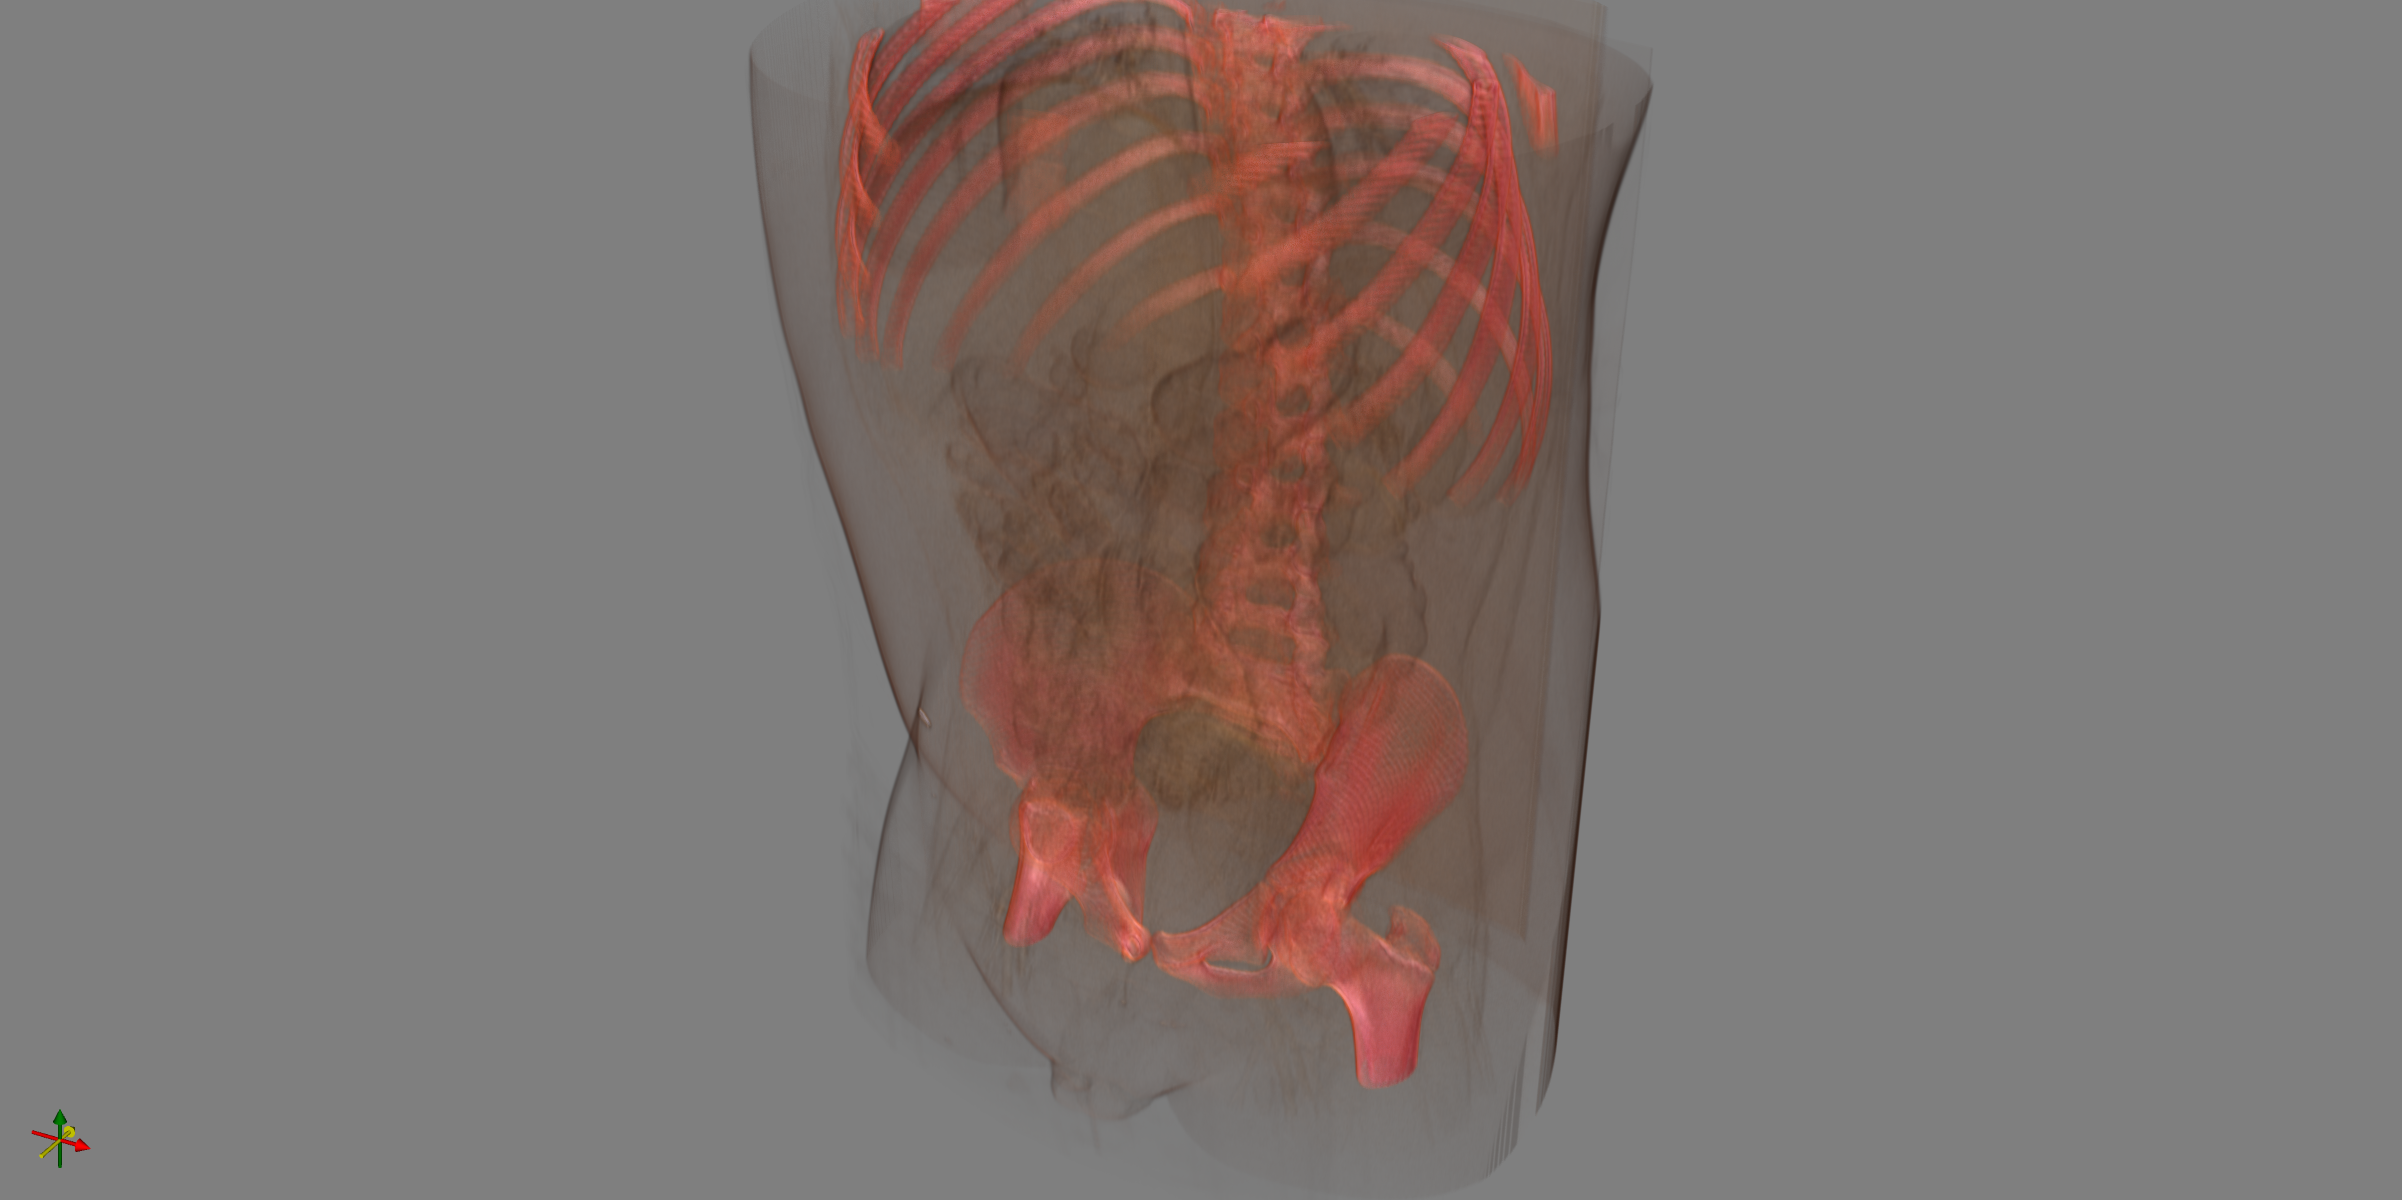
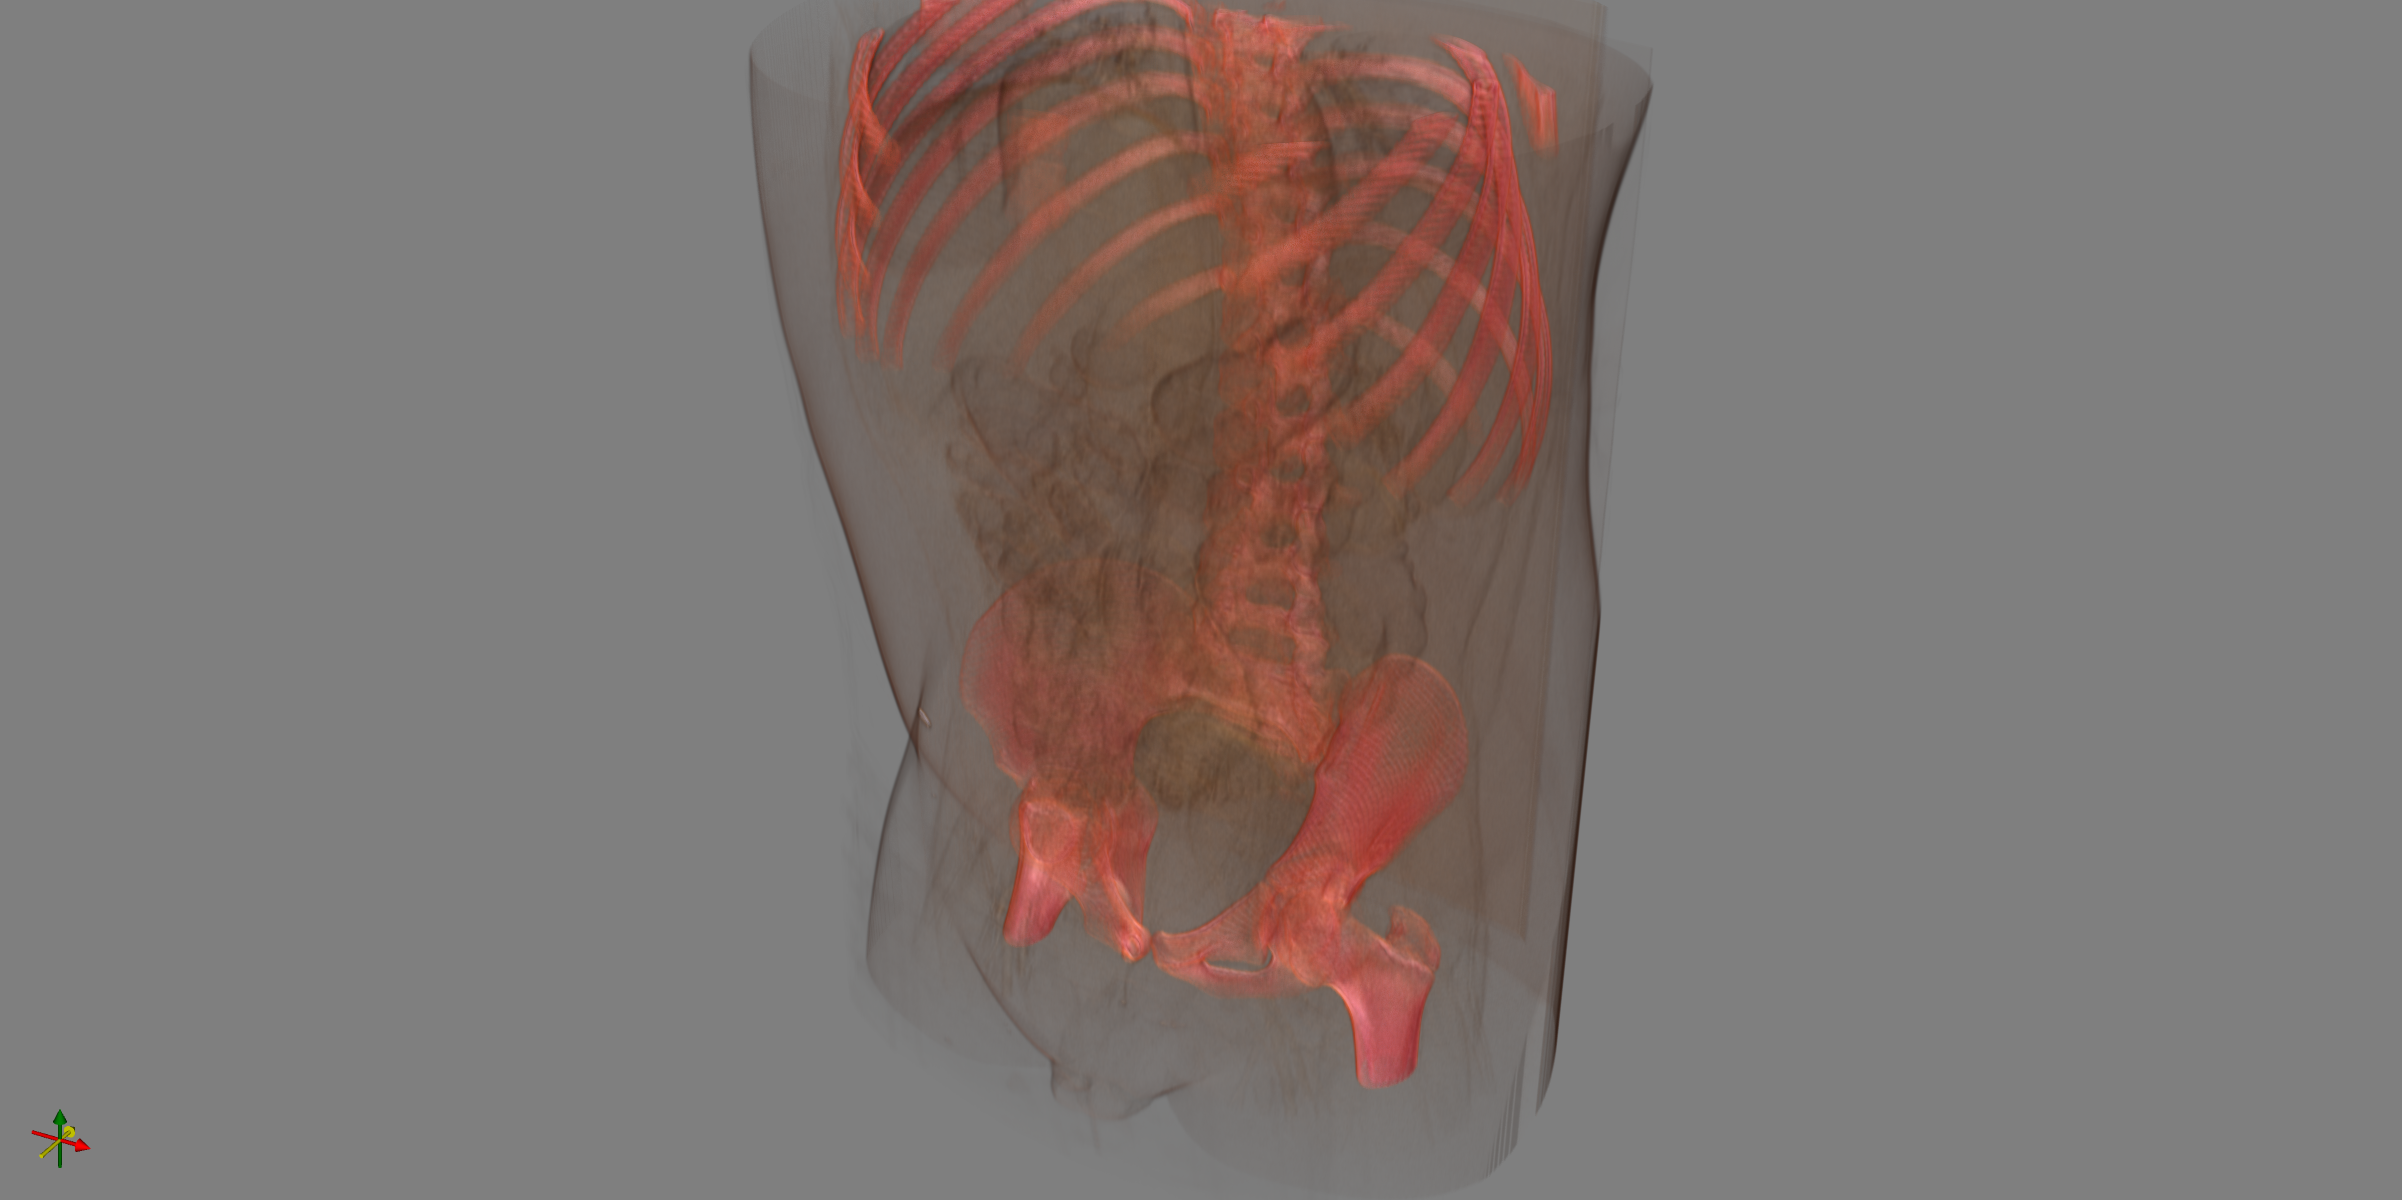

<IPython.core.display.Javascript object>

In [8]:
view(image=ped_ct_image, label_image=ped_bones_labelmap)

## 2.2. Loading DICOM Images and associated DICOM SEG objects from TCIA

### See Sections 2.1.1. to 2.1.3. for installing and importing dependencies and loading data from TCIA

### 2.2.1. Identify MR and SEG data from the PROSTATEx study

In [9]:
# The PROSTATEx study provides DICOM images and DICOM SEG data
pro_study_df = df.query( 'Collection=="PROSTATEx"' )
# The series_uid defines their directory where the MR data was stored on disk
pro_mr_series_uid = pro_study_df.SeriesInstanceUID[pro_study_df.Modality.eq('MR').idxmax()]
pro_mr_dir = dicom_data_dir + pro_mr_series_uid
# The series_uid defines where the RTSTRUCT was stored on disk.  It is stored in a single file.
pro_seg_series_uid = pro_study_df.SeriesInstanceUID[pro_study_df.Modality.eq('SEG').idxmax()]
pro_seg_file = dicom_data_dir + pro_seg_series_uid + "/00000001.dcm"

In [10]:
# Read the DICOM MR series' objects and reconstruct them into a 3D ITK image
#   The itk.F option is added to store the image in memory using floating-point precision pixels (useful if you will filter the image or use it with MONAI)
#   For more info on imread, see https://itkpythonpackage.readthedocs.io/en/master/Quick_start_guide.html 
pro_mr_image = itk.imread(pro_mr_dir, itk.F)

# Read the DICOM SEG object using pydicom and pydicom_seg
pro_seg_dicom = pydicom.dcmread(pro_seg_file)
seg_reader = pydicom_seg.MultiClassReader()
pro_seg_obj = seg_reader.read(pro_seg_dicom)

# Convert the DICOM SEG object into an itk image, with correct voxel origin, spacing, and directions in physical space
pro_seg_image = itk.GetImageFromArray(pro_seg_obj.data.astype(np.float32))
pro_seg_image.SetOrigin(pro_seg_obj.origin)
pro_seg_image.SetSpacing(pro_seg_obj.spacing)
pro_seg_image.SetDirection(pro_seg_obj.direction)


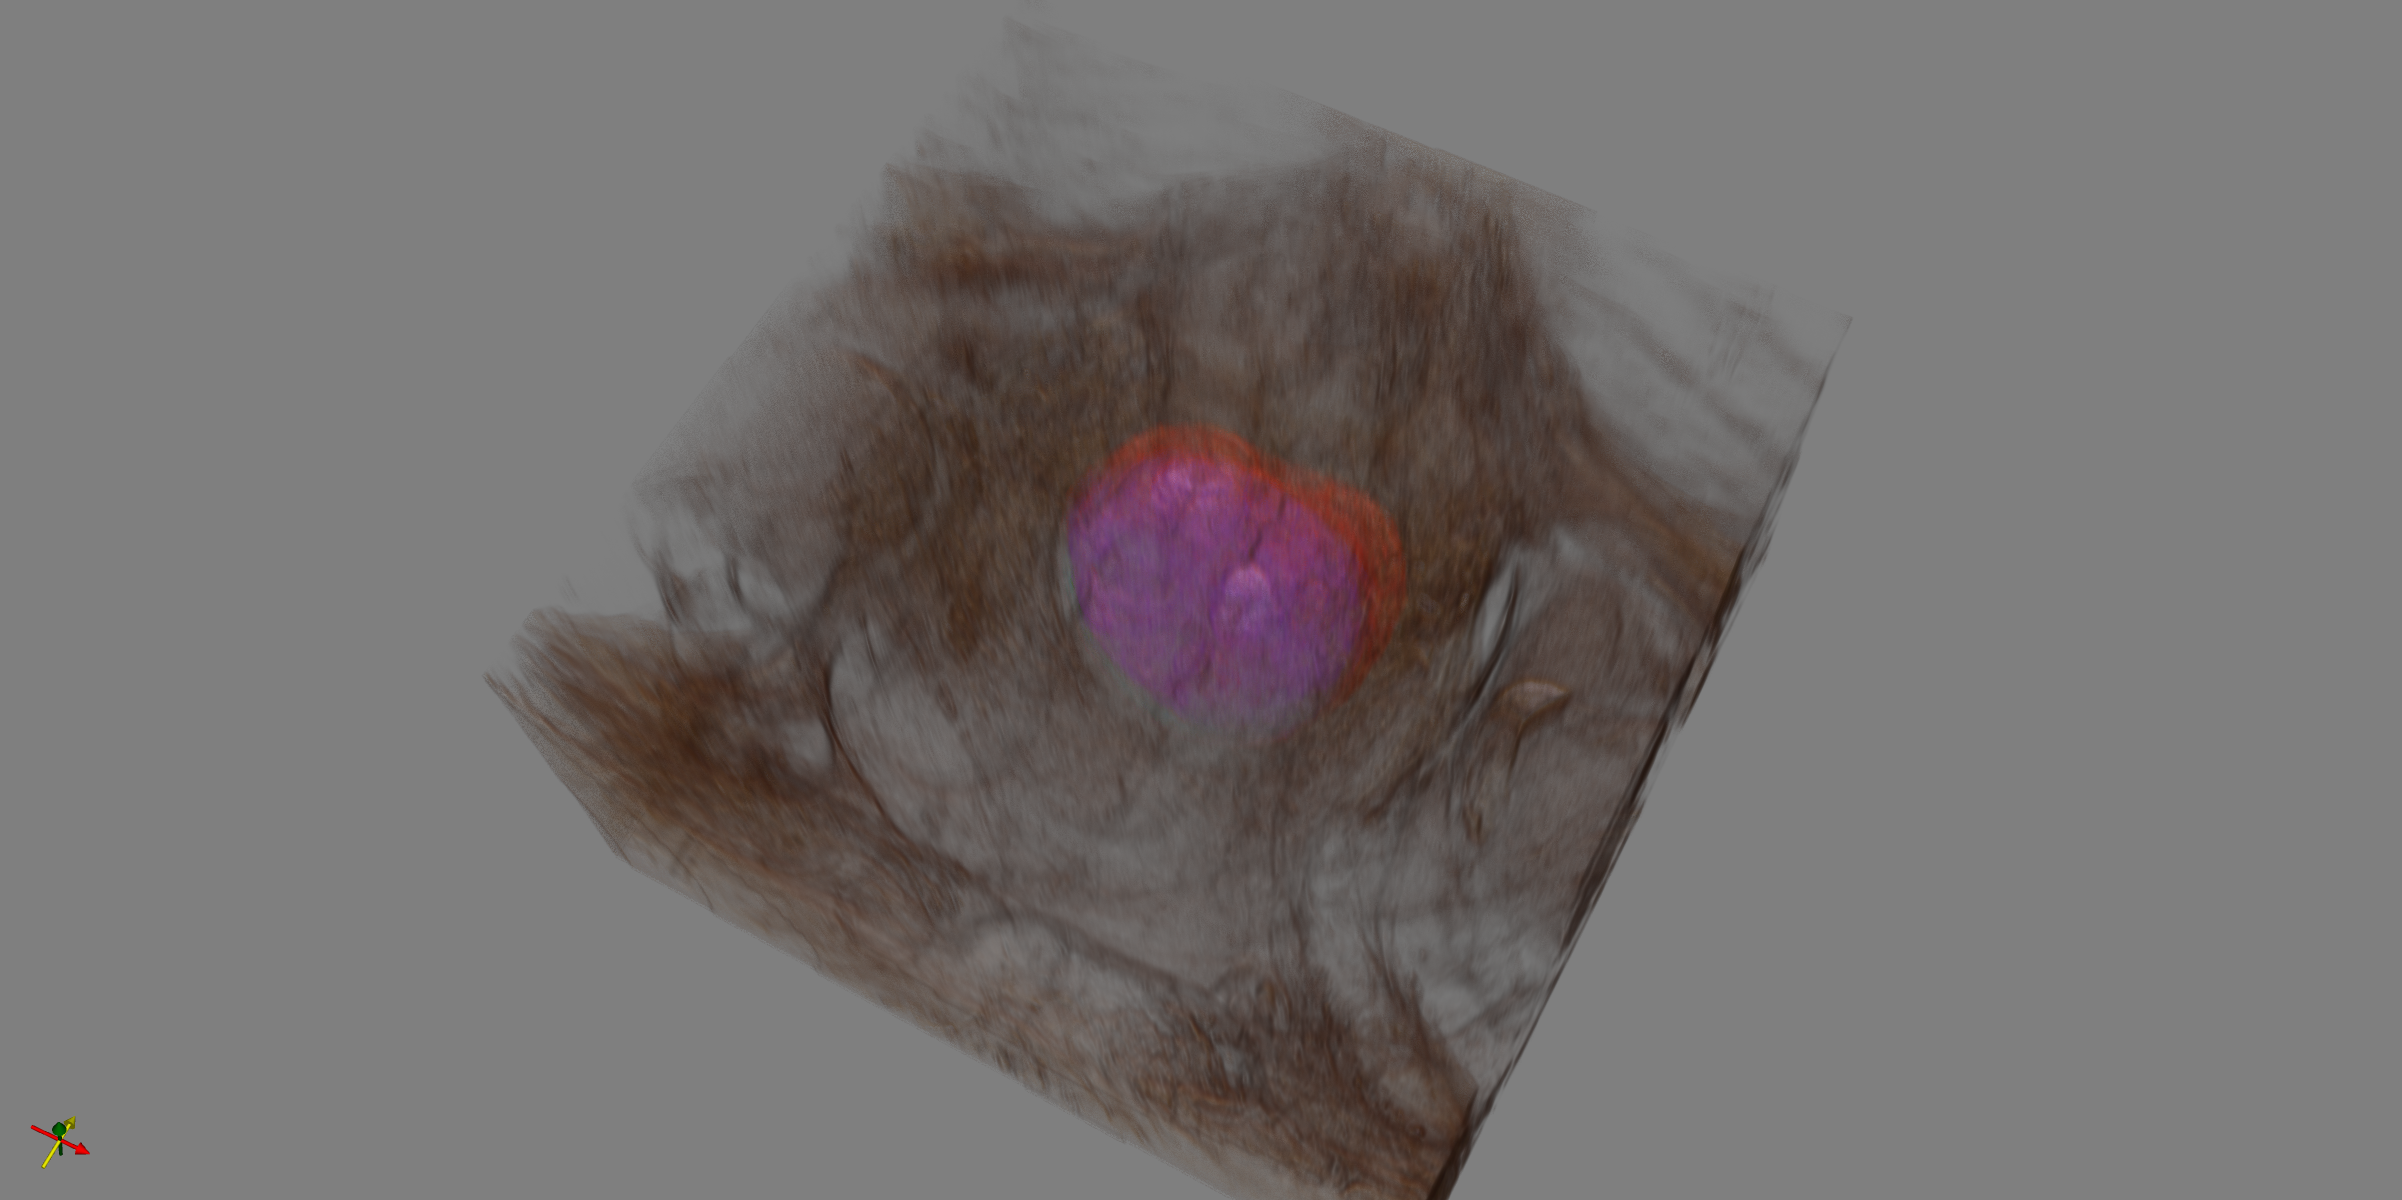
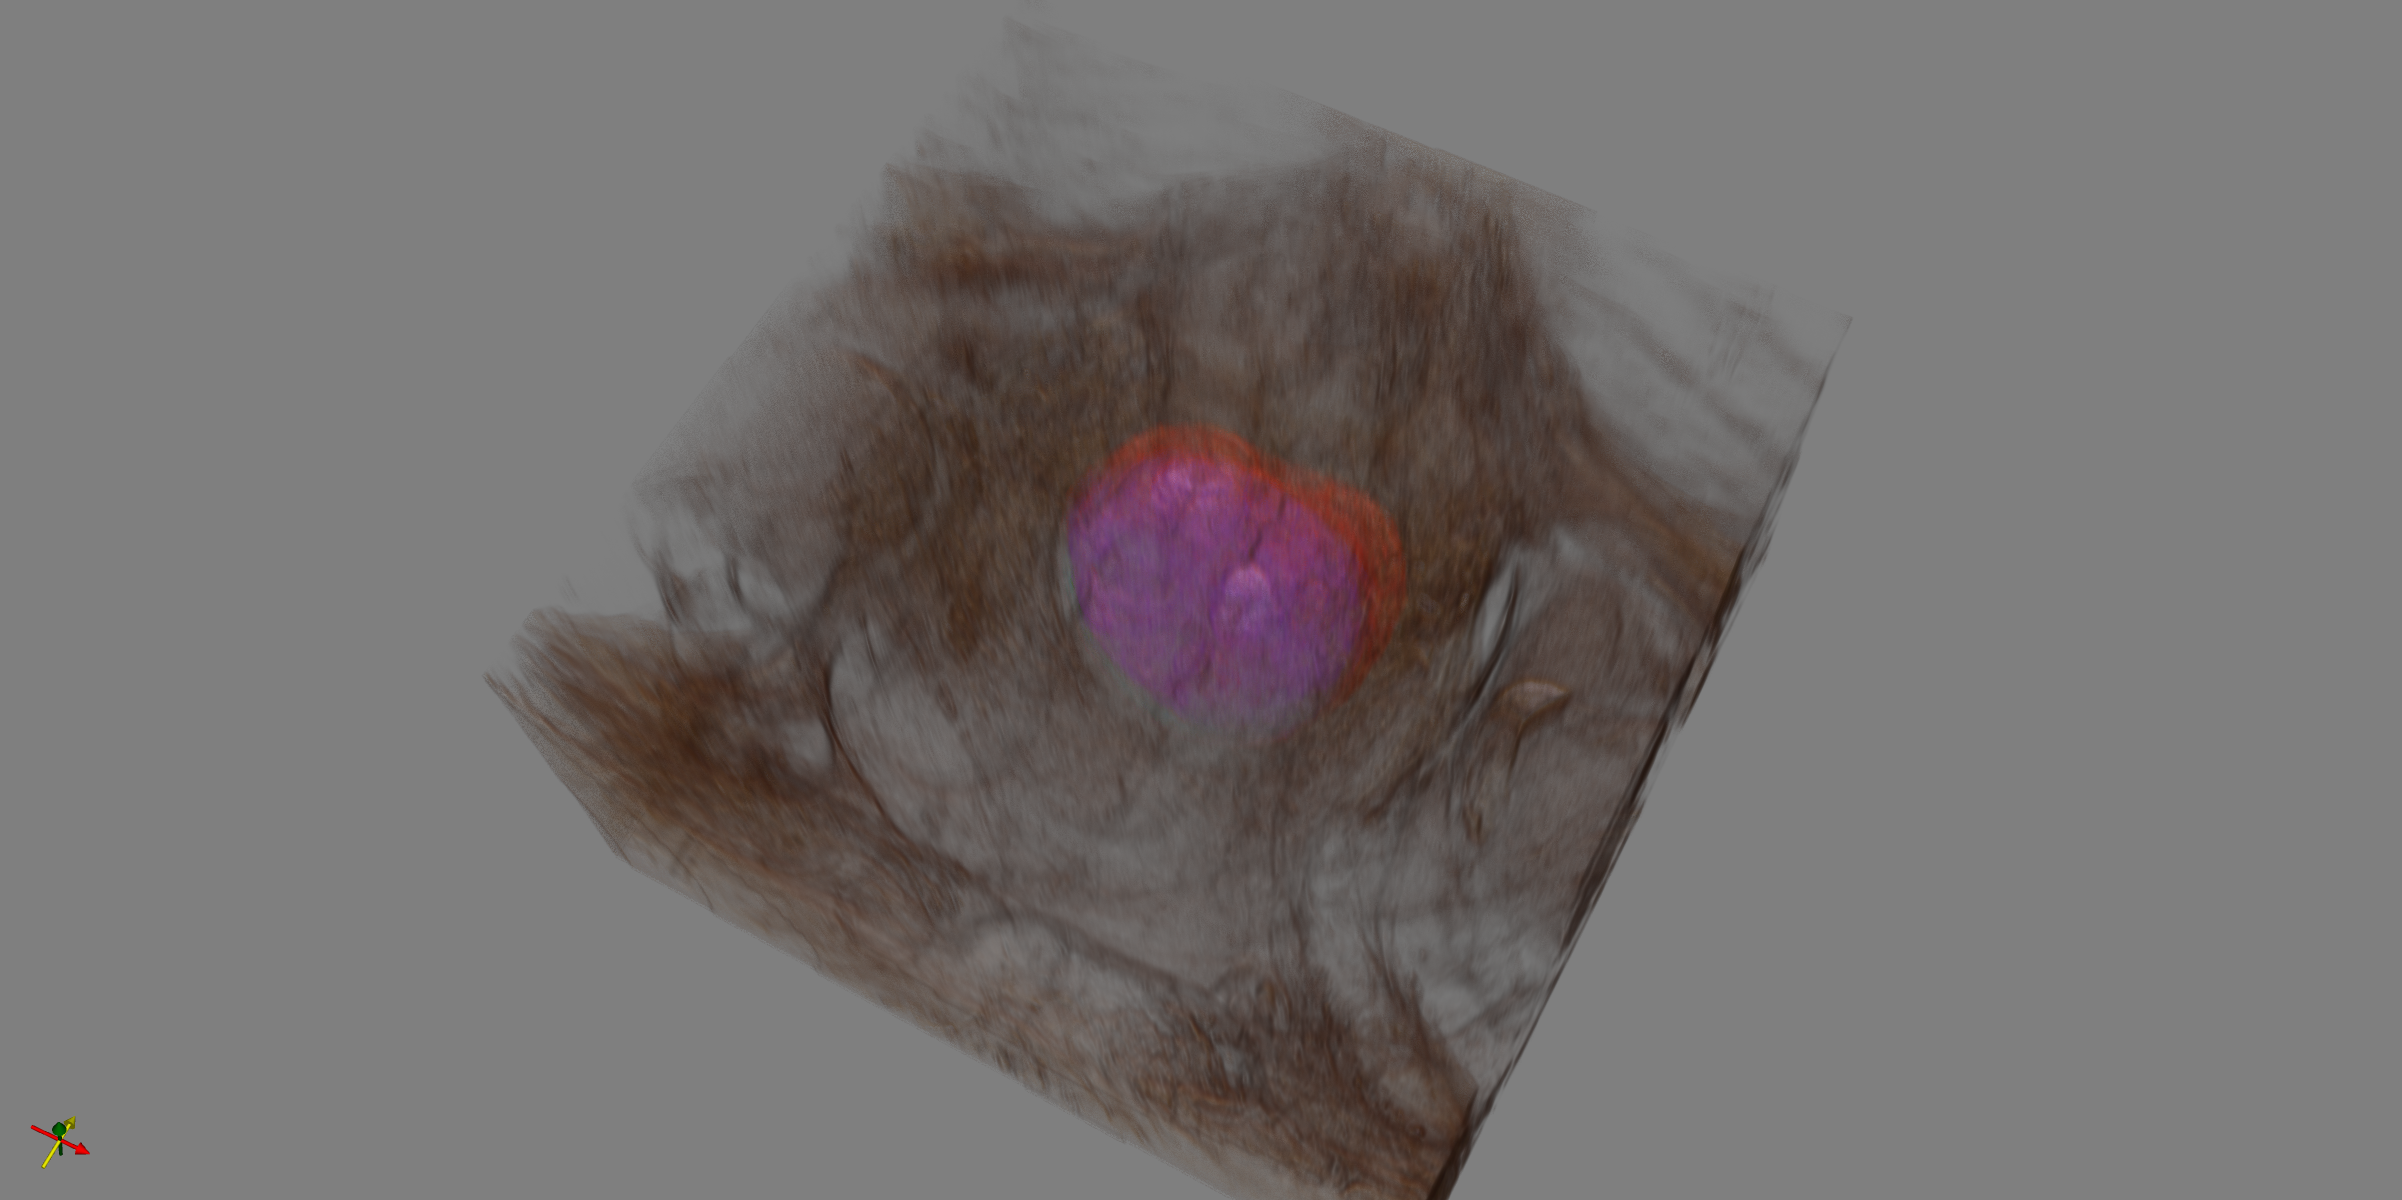

<IPython.core.display.Javascript object>

In [11]:
view(image=pro_mr_image, label_image=pro_seg_image)

# Acknowledgements
TCIA is funded by the [Cancer Imaging Program (CIP)](https://imaging.cancer.gov/), a part of the United States [National Cancer Institute (NCI)](https://www.cancer.gov/), and is managed by the [Frederick National Laboratory for Cancer Research (FNLCR)](https://frederick.cancer.gov/).

This notebook was created by [Justin Kirby](https://www.linkedin.com/in/justinkirby82/) and Qinyan Pan.  If you leverage this notebook or any TCIA datasets in your work please be sure to comply with the [TCIA Data Usage Policy](https://wiki.cancerimagingarchive.net/x/c4hF). In particular, make sure to cite the DOI(s) for the specific TCIA datasets you used in addition to the following paper!

## TCIA Citation

Clark, K., Vendt, B., Smith, K., Freymann, J., Kirby, J., Koppel, P., Moore, S., Phillips, S., Maffitt, D., Pringle, M., Tarbox, L., & Prior, F. (2013). The Cancer Imaging Archive (TCIA): Maintaining and Operating a Public Information Repository. Journal of Digital Imaging, 26(6), 1045–1057. https://doi.org/10.1007/s10278-013-9622-7